In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import seaborn as sns
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
batch_size = 64
NUM_CLASSES = 4
LEARNING_RATE = 0.001

In [3]:
train_dir = 'C:\\Users\\linkc\\Downloads\\dataset TA\\RiceLeafs\\train'
val_dir = 'C:\\Users\\linkc\\Downloads\\dataset TA\\RiceLeafs\\validation'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
)

class_names = train_ds.class_names
print(class_names)

Found 2684 files belonging to 4 classes.
Found 671 files belonging to 4 classes.
['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


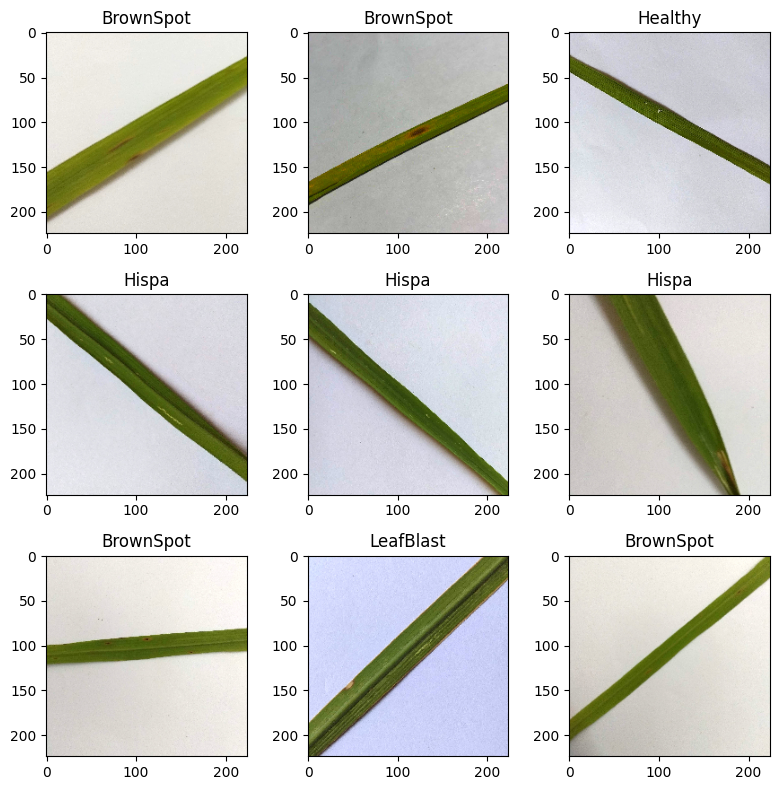

In [5]:
# Get the class labels
class_labels = os.listdir(train_dir)

# Define the figure size and number of rows and columns for the subplots
fig = plt.figure(figsize=(8, 8))
rows = 3
columns = 3

# Generate 9 random images and their corresponding labels
for i in range(1, rows * columns + 1):
    # Choose a random class label
    label = random.choice(class_labels)
    # Get the list of images for the chosen class label
    img_list = os.listdir(os.path.join(train_dir, label))
    # Choose a random image from the list
    img_file = random.choice(img_list)
    # Load the image using Keras' load_img function
    img = load_img(os.path.join(train_dir, label, img_file), target_size=(224, 224))
    # Add the subplot for the current image
    subplot = fig.add_subplot(rows, columns, i)
    # Set the title of the subplot to the current label
    subplot.title.set_text(label)
    # Display the image
    plt.imshow(img)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

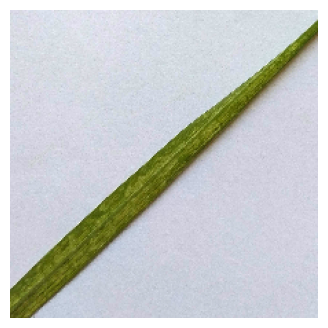

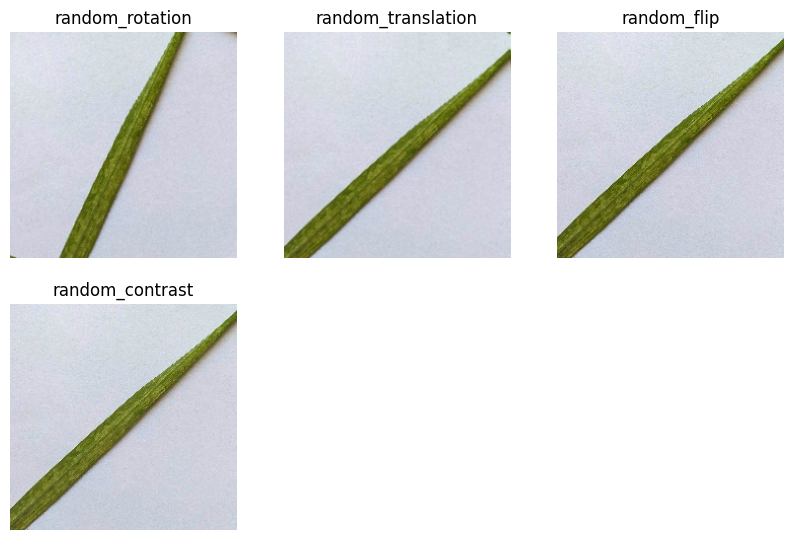

In [7]:
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

# Take one image from the dataset
for image, label in train_ds.take(1):
    img = image[0]
    plt.figure(figsize=(4, 4))
    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
    plt.show()

# Apply each augmentation technique to the image
plt.figure(figsize=(10, 10))
for i, layer in enumerate(data_augmentation.layers):
    augmented_img = layer(tf.expand_dims(img, 0))
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_img[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(layer.name)
plt.show()

In [8]:
UTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=UTOTUNE)
val_ds = train_ds = train_ds.cache().prefetch(buffer_size=UTOTUNE)

In [9]:
from tensorflow.keras import layers

normalization_layer = layers.experimental.preprocessing.Rescaling(1./256)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = data_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)


    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 4)                4054695   
                                                                 
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [11]:
def build_model(num_classes, input_shape):
    inputs = layers.Input(shape=input_shape)
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [12]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES, input_shape=(IMG_SIZE, IMG_SIZE, 3))

epochs = 40
# epochs = 5

hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

Epoch 1/40
42/42 - 313s - loss: 1.2729 - accuracy: 0.4892 - val_loss: 1.1246 - val_accuracy: 0.4702 - 313s/epoch - 7s/step
Epoch 2/40
42/42 - 277s - loss: 0.9666 - accuracy: 0.6200 - val_loss: 1.0365 - val_accuracy: 0.5145 - 277s/epoch - 7s/step
Epoch 3/40
42/42 - 285s - loss: 0.8371 - accuracy: 0.6602 - val_loss: 0.9690 - val_accuracy: 0.5645 - 285s/epoch - 7s/step
Epoch 4/40
42/42 - 292s - loss: 0.7929 - accuracy: 0.6807 - val_loss: 0.9063 - val_accuracy: 0.6054 - 292s/epoch - 7s/step
Epoch 5/40
42/42 - 251s - loss: 0.7336 - accuracy: 0.7027 - val_loss: 0.8509 - val_accuracy: 0.6449 - 251s/epoch - 6s/step
Epoch 6/40
42/42 - 222s - loss: 0.7145 - accuracy: 0.7060 - val_loss: 0.7871 - val_accuracy: 0.6848 - 222s/epoch - 5s/step
Epoch 7/40
42/42 - 212s - loss: 0.7058 - accuracy: 0.7116 - val_loss: 0.7319 - val_accuracy: 0.7142 - 212s/epoch - 5s/step
Epoch 8/40
42/42 - 211s - loss: 0.6731 - accuracy: 0.7247 - val_loss: 0.6878 - val_accuracy: 0.7344 - 211s/epoch - 5s/step
Epoch 9/40
42/42

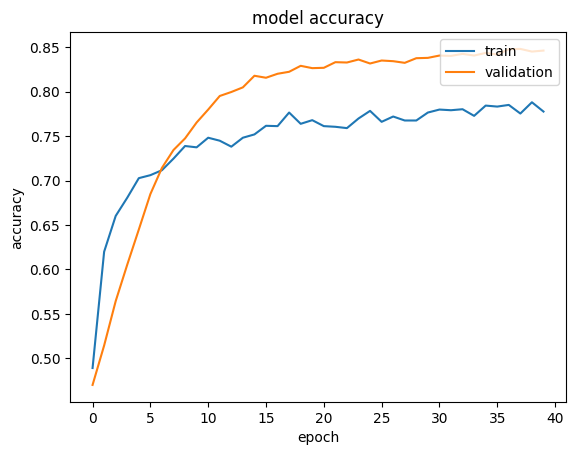

In [13]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper right")
    plt.show()

plot_hist(hist)

Epoch 1/30
42/42 - 232s - loss: 0.9396 - accuracy: 0.6665 - val_loss: 0.8379 - val_accuracy: 0.7150 - 232s/epoch - 6s/step
Epoch 2/30
42/42 - 228s - loss: 0.6809 - accuracy: 0.7388 - val_loss: 1.0895 - val_accuracy: 0.6822 - 228s/epoch - 5s/step
Epoch 3/30
42/42 - 709s - loss: 0.5726 - accuracy: 0.7642 - val_loss: 0.5110 - val_accuracy: 0.7936 - 709s/epoch - 17s/step
Epoch 4/30
42/42 - 230s - loss: 0.4981 - accuracy: 0.8048 - val_loss: 0.6538 - val_accuracy: 0.7645 - 230s/epoch - 5s/step
Epoch 5/30
42/42 - 242s - loss: 0.4553 - accuracy: 0.8200 - val_loss: 0.3683 - val_accuracy: 0.8472 - 242s/epoch - 6s/step
Epoch 6/30
42/42 - 226s - loss: 0.3860 - accuracy: 0.8424 - val_loss: 0.4349 - val_accuracy: 0.8275 - 226s/epoch - 5s/step
Epoch 7/30
42/42 - 248s - loss: 0.3309 - accuracy: 0.8659 - val_loss: 0.4085 - val_accuracy: 0.8342 - 248s/epoch - 6s/step
Epoch 8/30
42/42 - 247s - loss: 0.3063 - accuracy: 0.8815 - val_loss: 0.3002 - val_accuracy: 0.8778 - 247s/epoch - 6s/step
Epoch 9/30
42/4

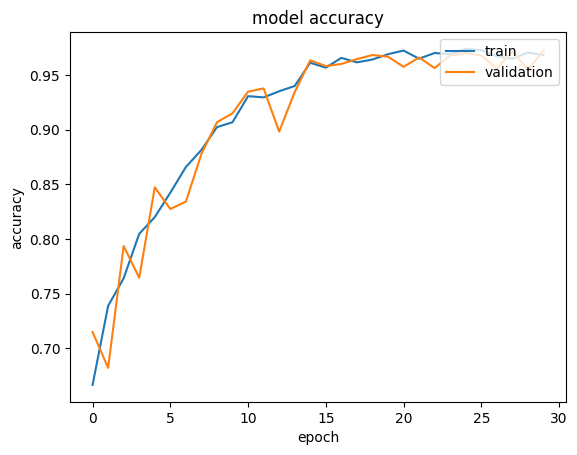

In [14]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

unfreeze_model(model)

epochs = 30
# epochs = 5

hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)
plot_hist(hist)

2/2 [==============================] - 2s 1s/step
[[ 416    2    0    0]
 [   1 1181    8    1]
 [   3   27  422    0]
 [   5   19    8  591]]
Accuracy: 0.9862146050670642
Precision: 0.9753871291628552
Recall: 0.9672707394980558
F1-score: 0.9713119792653735


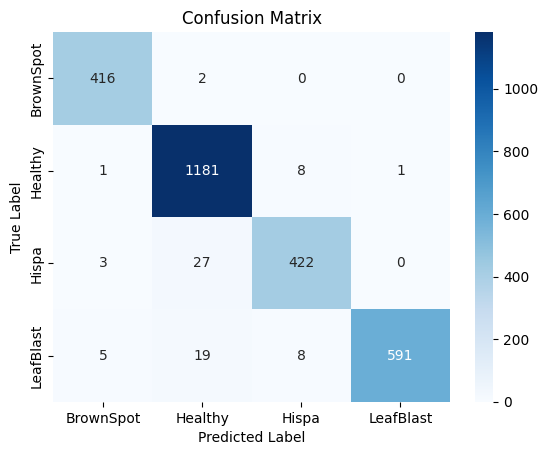

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np 

test_ds = val_ds.batch(batch_size)
y_true = []
y_pred = []
for x, y in val_ds:
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Calculate accuracy, precision, and recall
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)
accuracy = np.mean((TP + TN) / (TP + TN + FP + FN))
precision = np.mean(TP / (TP + FP))
recall = np.mean(TP / (TP + FN))
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [16]:
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the number of folds
n_splits = 5

acc_scores = []
prec_scores = []
rec_scores = []
f1_scores = []

# Split the data into two sets
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for i, (train_idx, val_idx) in enumerate(kf.split(train_dir)):  # train_dir is the path to the directory containing training images
    print(f"Fold {i+1}")

    # Create the training and validation datasets for this fold
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="categorical",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        validation_split=0.2,  # use 20% of the data for validation
        subset="training",
        seed=42,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="categorical",
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch_size,
        validation_split=0.2,
        subset="validation",
        seed=42,
    )

    # Build and compile the model
    with strategy.scope():
        model = build_model(num_classes=NUM_CLASSES, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Unfreeze some layers and recompile the model for fine-tuning
    unfreeze_model(model)

    # Fine-tune the model on the training dataset
    epochs = 30
#     epochs = 5
    hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=2)

    # Evaluate the model on the validation dataset
    y_true = []
    y_pred = []
    for images, labels in val_ds:
        pred = model.predict(images)
        y_true.extend(tf.argmax(labels, axis=1))
        y_pred.extend(tf.argmax(pred, axis=1))

    acc_scores.append(accuracy_score(y_true, y_pred))
    prec_scores.append(precision_score(y_true, y_pred, average='macro'))
    rec_scores.append(recall_score(y_true, y_pred, average='macro'))
    f1_scores.append(f1_score(y_true, y_pred, average='macro'))

    print("")
    print("================================================================================")
    print(f"Validation accuracy after fine-tuning: {acc_scores[-1]:.4f}")
    print(f"Validation precision after fine-tuning: {prec_scores[-1]:.4f}")
    print(f"Validation recall after fine-tuning: {rec_scores[-1]:.4f}")
    print(f"Validation F1 score after fine-tuning: {f1_scores[-1]:.4f}")
    print("================================================================================")
    print("")

# Calculate the average scores across all folds
print("")
print("================================================================================")
print(f"Average accuracy: {sum(acc_scores) / len(acc_scores):.4f}")
print(f"Average precision: {sum(prec_scores) / len(prec_scores):.4f}")
print(f"Average recall: {sum(rec_scores) / len(rec_scores):.4f}")
print(f"Average F1 score: {sum(f1_scores) / len(f1_scores):.4f}")

Fold 1
Found 2684 files belonging to 4 classes.
Using 2148 files for training.
Found 2684 files belonging to 4 classes.
Using 536 files for validation.
Epoch 1/30
34/34 - 171s - loss: 1.1079 - accuracy: 0.5805 - val_loss: 1.0811 - val_accuracy: 0.5205 - 171s/epoch - 5s/step
Epoch 2/30
34/34 - 161s - loss: 0.7432 - accuracy: 0.7020 - val_loss: 1.0163 - val_accuracy: 0.5802 - 161s/epoch - 5s/step
Epoch 3/30
34/34 - 161s - loss: 0.6395 - accuracy: 0.7430 - val_loss: 0.9301 - val_accuracy: 0.5989 - 161s/epoch - 5s/step
Epoch 4/30
34/34 - 160s - loss: 0.5722 - accuracy: 0.7682 - val_loss: 0.7725 - val_accuracy: 0.7108 - 160s/epoch - 5s/step
Epoch 5/30
34/34 - 153s - loss: 0.4988 - accuracy: 0.7924 - val_loss: 0.8065 - val_accuracy: 0.6772 - 153s/epoch - 4s/step
Epoch 6/30
34/34 - 159s - loss: 0.4744 - accuracy: 0.8110 - val_loss: 0.7548 - val_accuracy: 0.6959 - 159s/epoch - 5s/step
Epoch 7/30
34/34 - 156s - loss: 0.4224 - accuracy: 0.8305 - val_loss: 0.7967 - val_accuracy: 0.7127 - 156s/epo

Epoch 29/30
34/34 - 212s - loss: 0.0806 - accuracy: 0.9721 - val_loss: 1.1334 - val_accuracy: 0.7444 - 212s/epoch - 6s/step
Epoch 30/30
34/34 - 214s - loss: 0.0833 - accuracy: 0.9711 - val_loss: 1.1911 - val_accuracy: 0.7295 - 214s/epoch - 6s/step
1/1 [==============================] - 5s 5s/step

Validation accuracy after fine-tuning: 0.7295
Validation precision after fine-tuning: 0.7211
Validation recall after fine-tuning: 0.6915
Validation F1 score after fine-tuning: 0.6828

Fold 3
Found 2684 files belonging to 4 classes.
Using 2148 files for training.
Found 2684 files belonging to 4 classes.
Using 536 files for validation.
Epoch 1/30
34/34 - 230s - loss: 1.1272 - accuracy: 0.5847 - val_loss: 1.1029 - val_accuracy: 0.5317 - 230s/epoch - 7s/step
Epoch 2/30
34/34 - 220s - loss: 0.7782 - accuracy: 0.6979 - val_loss: 1.3775 - val_accuracy: 0.5429 - 220s/epoch - 6s/step
Epoch 3/30
34/34 - 221s - loss: 0.6339 - accuracy: 0.7435 - val_loss: 0.8467 - val_accuracy: 0.6493 - 221s/epoch - 7s/s

Epoch 20/30
34/34 - 163s - loss: 0.1560 - accuracy: 0.9418 - val_loss: 1.0906 - val_accuracy: 0.7295 - 163s/epoch - 5s/step
Epoch 21/30
34/34 - 162s - loss: 0.1619 - accuracy: 0.9395 - val_loss: 0.9641 - val_accuracy: 0.7388 - 162s/epoch - 5s/step
Epoch 22/30
34/34 - 162s - loss: 0.1380 - accuracy: 0.9497 - val_loss: 1.2484 - val_accuracy: 0.7295 - 162s/epoch - 5s/step
Epoch 23/30
34/34 - 162s - loss: 0.1415 - accuracy: 0.9427 - val_loss: 0.8850 - val_accuracy: 0.7481 - 162s/epoch - 5s/step
Epoch 24/30
34/34 - 163s - loss: 0.1077 - accuracy: 0.9628 - val_loss: 0.8664 - val_accuracy: 0.7425 - 163s/epoch - 5s/step
Epoch 25/30
34/34 - 162s - loss: 0.0888 - accuracy: 0.9702 - val_loss: 1.1232 - val_accuracy: 0.7295 - 162s/epoch - 5s/step
Epoch 26/30
34/34 - 162s - loss: 0.0949 - accuracy: 0.9688 - val_loss: 1.2058 - val_accuracy: 0.7556 - 162s/epoch - 5s/step
Epoch 27/30
34/34 - 163s - loss: 0.1189 - accuracy: 0.9567 - val_loss: 0.9332 - val_accuracy: 0.7537 - 163s/epoch - 5s/step
Epoch 28

1/1 [==============================] - 2s 2s/step


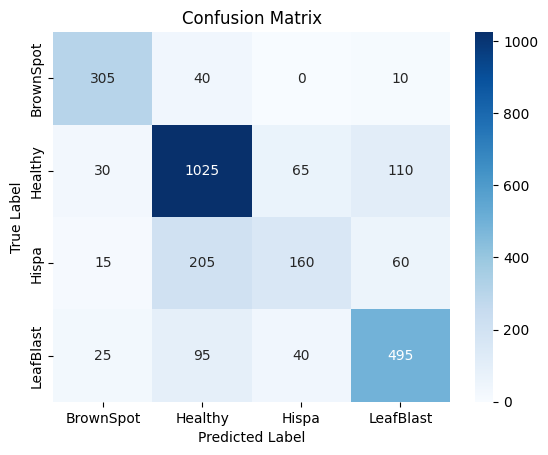

In [23]:
from sklearn.metrics import confusion_matrix

# create empty arrays for y_true and y_pred
y_true_all = []
y_pred_all = []

for i, (train_idx, val_idx) in enumerate(kf.split(train_dir)):
    # ... omitted code for clarity ...

    # Evaluate the model on the validation dataset
    y_true = []
    y_pred = []
    for images, labels in val_ds:
        pred = model.predict(images)
        y_true.extend(tf.argmax(labels, axis=1))
        y_pred.extend(tf.argmax(pred, axis=1))

    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

    # ... omitted code for clarity ...

# Calculate the confusion matrix across all folds
cm = confusion_matrix(y_true_all, y_pred_all)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()